In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.stats as ss
import func_plot as fp
from enigmatoolbox.datasets import load_sc, load_fc
from enigmatoolbox.permutation_testing import spin_test
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fc = load_fc('schaefer_100')[0]
sc = load_sc('schaefer_100')[0]
fc68 = load_fc('aparc')[0]
sc68 = load_sc('aparc')[0]
schaefer100 = nib.load('./Schaefer2018_100Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
dk68 = np.loadtxt('./fs_LR.dk.txt')
pos = pd.read_csv('Pos_Schizotypy_CT_Meta_NoGT_corr_final.csv')['meta.wthk.r'][:68]
neg = pd.read_csv('Neg_Schizotypy_CT_Meta_NoGT_corr_final.csv')['meta.wthk.r'][:68]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# Degree centrality spin test for 10k permutations

In [3]:
fc68_dc = np.sum(fc68, axis=0)
sc68_dc = np.sum(sc68, axis=0)

## Postive and FC_DC
pspin = spin_test(fc68_dc, pos, surface_name='fsa5', parcellation_name='aparc',
        type='pearson', n_rot=10000, null_dist=False)

print(ss.pearsonr(fc68_dc, pos), 'P_spin', pspin)

PearsonRResult(statistic=-0.536476564167947, pvalue=2.4103937789354487e-06) P_spin 0.0009500000000000001


In [4]:
## Postive and SC_DC
pspin = spin_test(sc68_dc, pos, surface_name='fsa5', parcellation_name='aparc',
        type='pearson', n_rot=10000, null_dist=False)

print(ss.pearsonr(sc68_dc, pos), 'P_spin', pspin)

PearsonRResult(statistic=-0.25094509056132586, pvalue=0.03900477786795509) P_spin 0.0394


In [5]:
## Negative and FC_DC
pspin = spin_test(fc68_dc, neg, surface_name='fsa5', parcellation_name='aparc',
        type='pearson', n_rot=10000, null_dist=False)

print(ss.pearsonr(fc68_dc, neg), 'P_spin', pspin)

PearsonRResult(statistic=-0.4754826558085872, pvalue=4.1745604347093285e-05) P_spin 0.01695


In [6]:
## Negative and FC_DC
pspin = spin_test(sc68_dc, neg, surface_name='fsa5', parcellation_name='aparc',
        type='pearson', n_rot=10000, null_dist=False)

print(ss.pearsonr(sc68_dc, neg), 'P_spin', pspin)

PearsonRResult(statistic=-0.12876208338904477, pvalue=0.29534056023241134) P_spin 0.19779999999999998


# Network-dc considering

In [7]:
# epicenter analysis
# 3 axes are pearsonr, oringinal p, and residual p with 1000 spin tests

fc_epi_pos = np.zeros((68,3))
sc_epi_pos = np.zeros((68,3))
fc_epi_neg = np.zeros((68,3))
sc_epi_neg = np.zeros((68,3))

def resi(x,cov):
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    model = OLS(x, add_constant(cov)).fit()
    pred = model.predict(add_constant(cov))

    return x - pred

pos_res_fcdc = resi(pos, fc68_dc)
pos_res_scdc = resi(pos, sc68_dc)
neg_res_fcdc = resi(neg, fc68_dc)
neg_res_scdc = resi(neg, sc68_dc)

for i in range(68):
    fc_epi_pos[i,:2] = ss.pearsonr(pos_res_fcdc, fc68[i])
    fc_epi_pos[i,2] = spin_test(pos_res_fcdc, fc68[i], surface_name='fsa5', parcellation_name='aparc',
                                type='pearson', n_rot=1000, null_dist=False)
    sc_epi_pos[i,:2] = ss.pearsonr(pos_res_scdc, sc68[i])
    sc_epi_pos[i,2] = spin_test(pos_res_scdc, sc68[i], surface_name='fsa5', parcellation_name='aparc',
                                type='pearson', n_rot=1000, null_dist=False)
    fc_epi_neg[i,:2] = ss.pearsonr(neg_res_fcdc, fc68[i])
    fc_epi_neg[i,2] = spin_test(neg_res_fcdc, fc68[i], surface_name='fsa5', parcellation_name='aparc',
                                type='pearson', n_rot=1000, null_dist=False)
    sc_epi_neg[i,:2] = ss.pearsonr(neg_res_scdc, sc68[i])
    sc_epi_neg[i,2] = spin_test(neg_res_scdc, sc68[i], surface_name='fsa5', parcellation_name='aparc',
                                type='pearson', n_rot=1000, null_dist=False)

In [8]:
np.savetxt('./fcdc_residual_epicenter_pos_dk68.txt', fc_epi_pos)
np.savetxt('./scdc_residual_epicenter_pos_dk68.txt', sc_epi_pos)
np.savetxt('./fcdc_residual_epicenter_neg_dk68.txt', fc_epi_neg)
np.savetxt('./scdc_residual_epicenter_neg_dk68.txt', sc_epi_neg)

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define color range from blue to grey
colors = [
    "#1f77b4",  # blue
    "#c6d4e1",  # light blue
    "white",    # middle white
    "#999999",  # light grey
    "black"   # darker grey
]

# Create the colormap
blue_grey_cmap = LinearSegmentedColormap.from_list("blue_grey", colors)

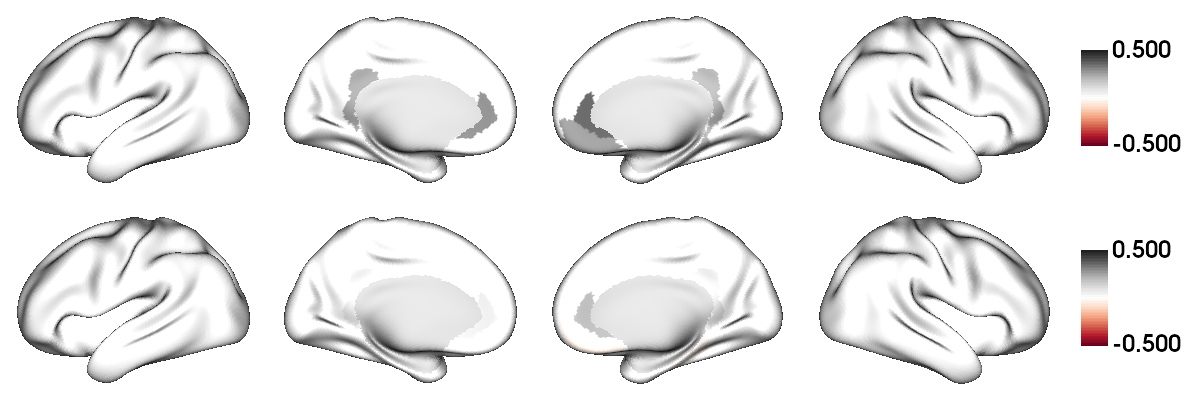

In [10]:
tmp1 = fc_epi_pos.copy()
tmp1[:,0][tmp1[:,2]>0.05] = 0
tmp2 = fc_epi_neg.copy()
tmp2[:,0][tmp1[:,2]>0.05] = 0
tmp = [tmp1[:,0], tmp2[:,0]]
plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = dk68.copy()
  for j in range(68):
    plot[i][dk68==j+1] = tmp[i][j]
  plot[i][schaefer100==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdGy', color_range=(-0.5,0.5),
                display=True, filename='./fc_epicenter_residual_dk68.png')

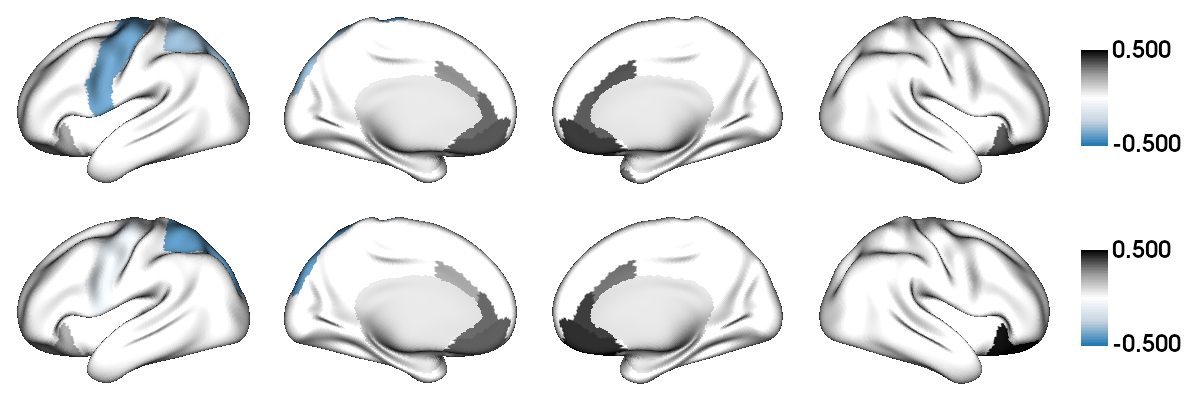

In [11]:
tmp1 = sc_epi_pos.copy()
tmp1[:,0][tmp1[:,2]>0.05] = 0
tmp2 = sc_epi_neg.copy()
tmp2[:,0][tmp1[:,2]>0.05] = 0
tmp = [tmp1[:,0], tmp2[:,0]]
plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = dk68.copy()
  for j in range(68):
    plot[i][dk68==j+1] = tmp[i][j]
  plot[i][schaefer100==0] = np.nan
  
fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap=blue_grey_cmap, color_range=(-0.5,0.5),
                display=True, filename='./sc_epicenter_residual_dk68.png')

# convert from dk68 to schaefer100

In [12]:
pos_100 = np.zeros(100)
neg_100 = np.zeros(100)
pos_tmp = np.zeros(dk68.shape)
neg_tmp = np.zeros(dk68.shape)
for i in range(68):
    pos_tmp[dk68==i+1] = pos[i]
    neg_tmp[dk68==i+1] = neg[i]
for j in range(100):
    pos_100[j] = np.nanmean(pos_tmp[schaefer100==j+1])
    neg_100[j] = np.nanmean(neg_tmp[schaefer100==j+1])

# results of the convertion
ss.pearsonr(pos_100, neg_100), ss.pearsonr(pos, neg)

(PearsonRResult(statistic=0.2658792202823281, pvalue=0.007502626457933348),
 PearsonRResult(statistic=0.4472126802498643, pvalue=0.00013162768850998578))

PearsonRResult(statistic=-0.43201313539631847, pvalue=7.185610790490474e-06) P_spin 0.0025


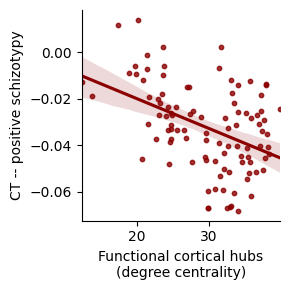

In [13]:
fc100_dc = np.sum(fc, axis=0)
sc100_dc = np.sum(sc, axis=0)

## Postive and FC_DC
pspin = spin_test(fc100_dc, pos_100, surface_name='fsa5', parcellation_name='schaefer_100',
        type='pearson', n_rot=1000, null_dist=False)

print(ss.pearsonr(fc100_dc, pos_100), 'P_spin', pspin)

fig, ax = plt.subplots(figsize=(3,3))
sns.regplot(fc100_dc, pos_100, ax=ax,
            color='darkred', scatter_kws={'s':10})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Functional cortical hubs\n(degree centrality)")
ax.set_ylabel("CT -- positive schizotypy")

fig.tight_layout()
fig.savefig('./fcdc_pos_scheafer100.png', transparent=True, dpi=300)

PearsonRResult(statistic=0.08342636805770126, pvalue=0.40924964335272074) P_spin 0.3925


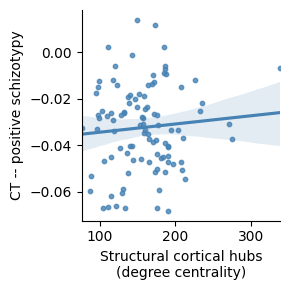

In [14]:
## Postive and SC_DC
pspin = spin_test(sc100_dc, pos_100, surface_name='fsa5', parcellation_name='schaefer_100',
        type='pearson', n_rot=1000, null_dist=False)

print(ss.pearsonr(sc100_dc, pos_100), 'P_spin', pspin)

fig, ax = plt.subplots(figsize=(3,3))
sns.regplot(sc100_dc, pos_100, ax=ax,
            color='steelblue', scatter_kws={'s':10})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Structural cortical hubs\n(degree centrality)")
ax.set_ylabel("CT -- positive schizotypy")

fig.tight_layout()
fig.savefig('./scdc_pos_scheafer100.png', transparent=True, dpi=300)

PearsonRResult(statistic=-0.29588311081468366, pvalue=0.0028002244223995793) P_spin 0.073


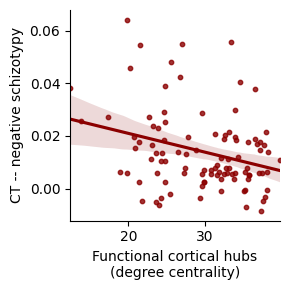

In [15]:
## Negative and FC_DC
pspin = spin_test(fc100_dc, neg_100, surface_name='fsa5', parcellation_name='schaefer_100',
        type='pearson', n_rot=1000, null_dist=False)

print(ss.pearsonr(fc100_dc, neg_100), 'P_spin', pspin)

fig, ax = plt.subplots(figsize=(3,3))
sns.regplot(fc100_dc, neg_100, ax=ax,
            color='darkred', scatter_kws={'s':10})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Functional cortical hubs\n(degree centrality)")
ax.set_ylabel("CT -- negative schizotypy")

fig.tight_layout()
fig.savefig('./fcdc_neg_scheafer100.png', transparent=True, dpi=300)

PearsonRResult(statistic=0.4004792053490289, pvalue=3.649501392870241e-05) P_spin 0.003


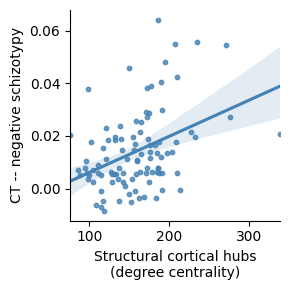

In [16]:
## Negative and SC_DC
pspin = spin_test(sc100_dc, neg_100, surface_name='fsa5', parcellation_name='schaefer_100',
        type='pearson', n_rot=1000, null_dist=False)

print(ss.pearsonr(sc100_dc, neg_100), 'P_spin', pspin)

fig, ax = plt.subplots(figsize=(3,3))
sns.regplot(sc100_dc, neg_100, ax=ax,
            color='steelblue', scatter_kws={'s':10})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Structural cortical hubs\n(degree centrality)")
ax.set_ylabel("CT -- negative schizotypy")

fig.tight_layout()
fig.savefig('./scdc_neg_scheafer100.png', transparent=True, dpi=300)

In [17]:
# epicenter analysis


fc_epi_pos = np.zeros((100,3))
sc_epi_pos = np.zeros((100,3))
fc_epi_neg = np.zeros((100,3))
sc_epi_neg = np.zeros((100,3))

for i in range(68):
    fc_epi_pos[i,:2] = ss.pearsonr(pos_100, fc[i])
    fc_epi_pos[i,2] = spin_test(pos_100, fc[i], surface_name='fsa5', parcellation_name='schaefer_100',
                                type='pearson', n_rot=1000, null_dist=False)
    sc_epi_pos[i,:2] = ss.pearsonr(pos_100, sc[i])
    sc_epi_pos[i,2] = spin_test(pos_100, sc[i], surface_name='fsa5', parcellation_name='schaefer_100',
                                type='pearson', n_rot=1000, null_dist=False)
    fc_epi_neg[i,:2] = ss.pearsonr(neg_100, fc[i])
    fc_epi_neg[i,2] = spin_test(neg_100, fc[i], surface_name='fsa5', parcellation_name='schaefer_100',
                                type='pearson', n_rot=1000, null_dist=False)
    sc_epi_neg[i,:2] = ss.pearsonr(neg_100, sc[i])
    sc_epi_neg[i,2] = spin_test(neg_100, sc[i], surface_name='fsa5', parcellation_name='schaefer_100',
                                type='pearson', n_rot=1000, null_dist=False)

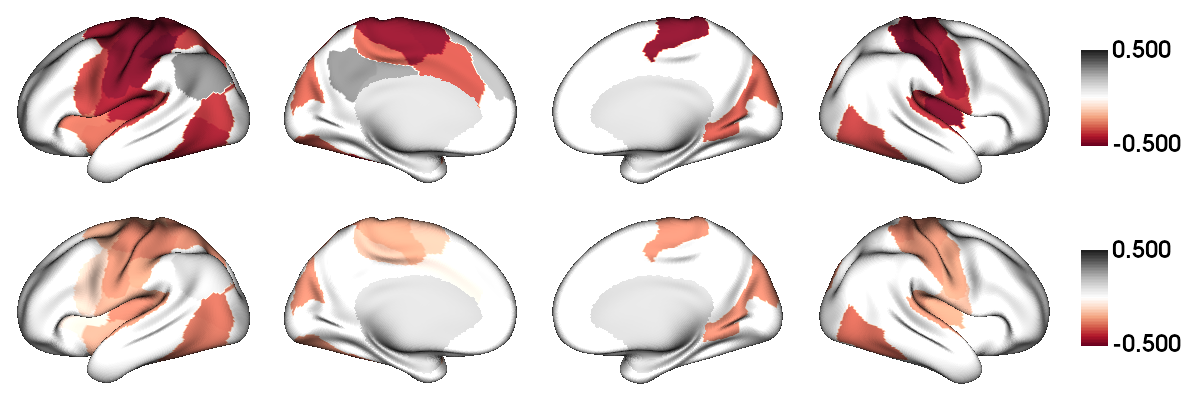

In [18]:
tmp1 = fc_epi_pos.copy()
tmp1[:,0][tmp1[:,2]>0.05] = 0
tmp2 = fc_epi_neg.copy()
tmp2[:,0][tmp1[:,2]>0.05] = 0
tmp = [tmp1[:,0], tmp2[:,0]]

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = schaefer100.copy()
  for j in range(100):
    plot[i][schaefer100==j+1] = tmp[i][j]
  plot[i][schaefer100==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdGy', color_range=(-0.5,0.5),
                display=True, filename='./fc_epicenter_scheafer100.png')

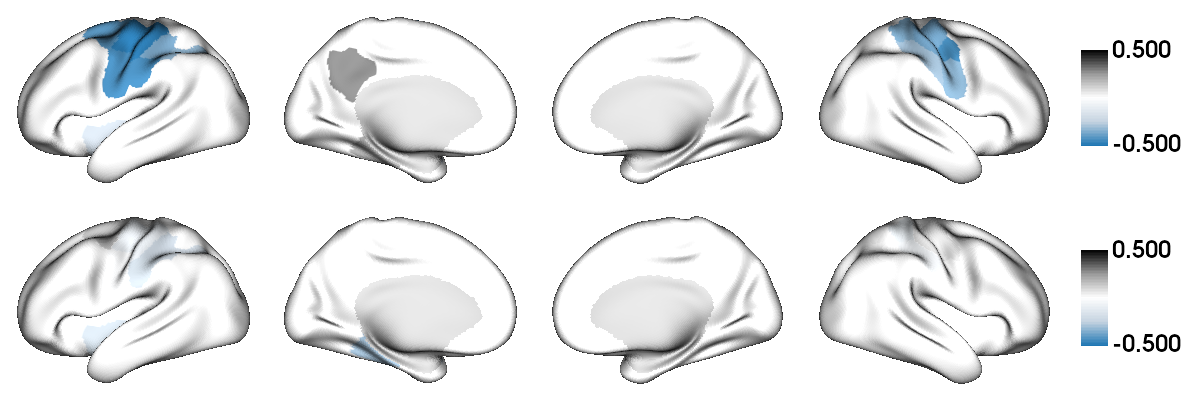

In [19]:
tmp1 = sc_epi_pos.copy()
tmp1[:,0][tmp1[:,2]>0.05] = 0
tmp2 = sc_epi_neg.copy()
tmp2[:,0][tmp1[:,2]>0.05] = 0
tmp = [tmp1[:,0], tmp2[:,0]]

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = schaefer100.copy()
  for j in range(100):
    plot[i][schaefer100==j+1] = tmp[i][j]
  plot[i][schaefer100==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap=blue_grey_cmap, color_range=(-0.5,0.5),
                display=True, filename='./sc_epicenter_scheafer100.png')